## Classification and dimensionality reduction

In [1]:
%load_ext autoreload
%autoreload 2

## Imports of packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import torch
from torch import nn
from torchvision import transforms
from torchvision.datasets import SVHN
from torchvision.models import resnet18
from PIL import Image

In [12]:
from triplets.transformers import FeatureExtractor
from triplets.datasets import TripletDataset

In [4]:
batch_size = 1
n_features = 512
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SEED = 100
np.random.seed(SEED)

Defining transformations of the dataset

In [5]:
preprocess = transforms.Compose([            
 transforms.Resize(256),                    
 transforms.CenterCrop(224),                
 transforms.ToTensor(),                     
 transforms.Normalize(                      
 mean=[0.485, 0.456, 0.406],                
 std=[0.229, 0.224, 0.225]                  
 )])

Loading dataset

In [6]:
dataset_train = SVHN(root = 'data/', download=True, split='train', transform=preprocess)
dataset_test = SVHN(root = 'data/', download=True, split='test', transform=preprocess)

Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat


In [7]:
indices = np.random.randint(low=0, high=len(dataset_train), size=25)

We are going to plot several examples from the dataset to inspect whether we can expect some nontrivial cases
during training our architecture.

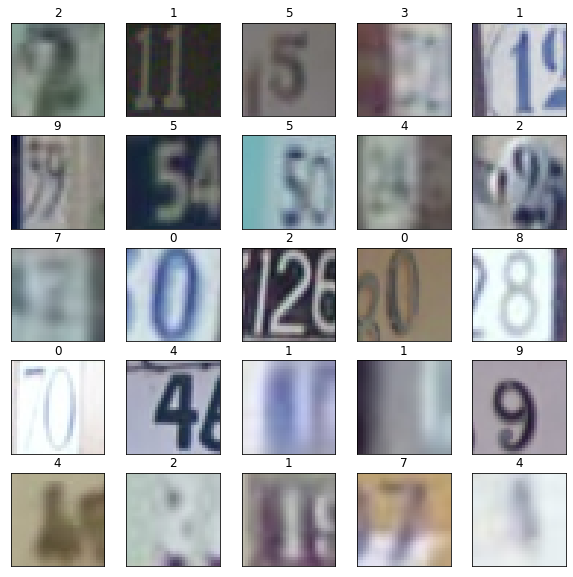

In [8]:
fig, ax = plt.subplots(nrows = 5, ncols=5, figsize=(10, 10))
axes = ax.flatten()
for ax, image, label in zip(axes, dataset_train.data[indices], dataset_train.labels[indices]):
    plt.sca(ax)
    plt.imshow(np.moveaxis(image, 0, 2))
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.title(label)

One can see that there are several issues connected with this dataset:
* Blurry images
* Digits other than labeled are present in the image
<br>

At least from the brief inspection we can except that out dataset is labeled correctly.

Loading pretrained resnet
#TODO: Describe the network and justify its use

In [9]:
model = resnet18(pretrained=True)
model.eval();

Defining extractor using custom class to extract features from last cnn pretrained layer.

In [10]:
extractor = FeatureExtractor(model=model, n_remove_layers=1, n_features=n_features, device=device)

In [20]:
np.ones(len(dataset_train))

array([1., 1., 1., ..., 1., 1., 1.])

In [21]:
triplet = TripletDataset(dataset=dataset_train, num_triplets=100, groups=dataset_train.labels)

In [26]:
triplet.generate_triplet()

(31389, 71032, 63448)

In [1]:
X_train_codes, y_train_codes = extractor.extract_features(dataset_train)
X_test_codes, y_test_codes = extractor.extract_features(dataset_test)

Training kNN-classifier on top of cnn codes with cross-validated grid search

In [ ]:
params = {'n_neighbors': list(range(3, 10))}
classifier = KNeighborsClassifier()
clf = GridSearchCV(classifier, params, cv=10)
clf.fit(X_train_codes, y_train_codes)

In [ ]:
train_predictions = clf.predict(X_train_codes)
test_predictions = clf.predict(X_test_codes)